In [1]:
# A lot of inspiration for the feature engineering comes from
#https://github.com/CasellaJr/wine_pytorch_deep_learning/blob/main/BrunoCasellaNeuralComputing.ipynb

import torch
import torchvision
import matplotlib
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import KFold
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split, ConcatDataset, SubsetRandomSampler

In [2]:
# Read in red wine data

wine_dataset = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';')
wine_dataset2 = wine_dataset.copy(deep=True)


<Axes: >

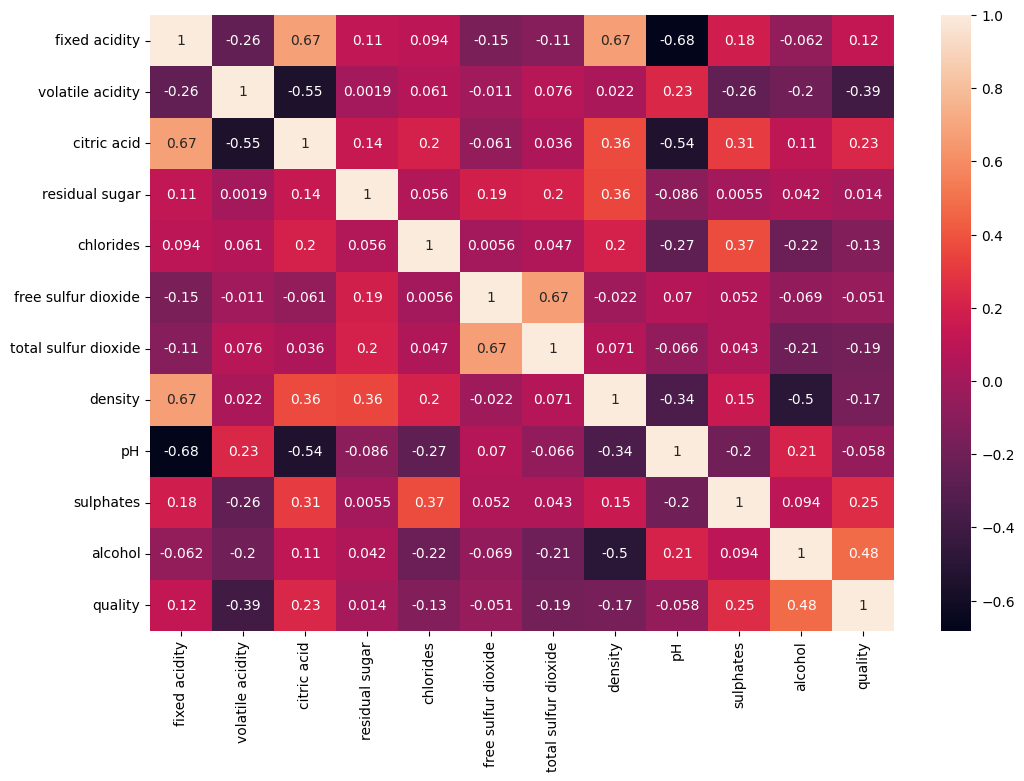

In [3]:
plt.figure(figsize=(12,8))
sns.heatmap(wine_dataset.corr(), color = "r", annot=True)

In [4]:
wine_dataset = wine_dataset.drop(columns=['citric acid','density','free sulfur dioxide'])

In [5]:
outliers = []  # list to store outliers value

# see what outliers exist
def find_outliers(data):
    quantile1, quantile3 = np.percentile(data, [25, 75])
    interquartile= quantile3 - quantile1
    lower_value = quantile1 - (1.5 * interquartile)
    upper_value = quantile3 + (1.5 * interquartile)

    # if value is lower than lowerbound value than outlier
    # if value is higher than upperbouind value than outlier
    for i in data:
        if(i < lower_value or i > upper_value):
            outliers.append(i)

    return lower_value, upper_value

In [6]:
# Custom boxplot
def box_plot(data, title =""):
    # Make the figure object
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, y = 1, fontsize = 30)
    sns.set(font_scale = 2)
    sns.boxplot(data = data, orient = "h")

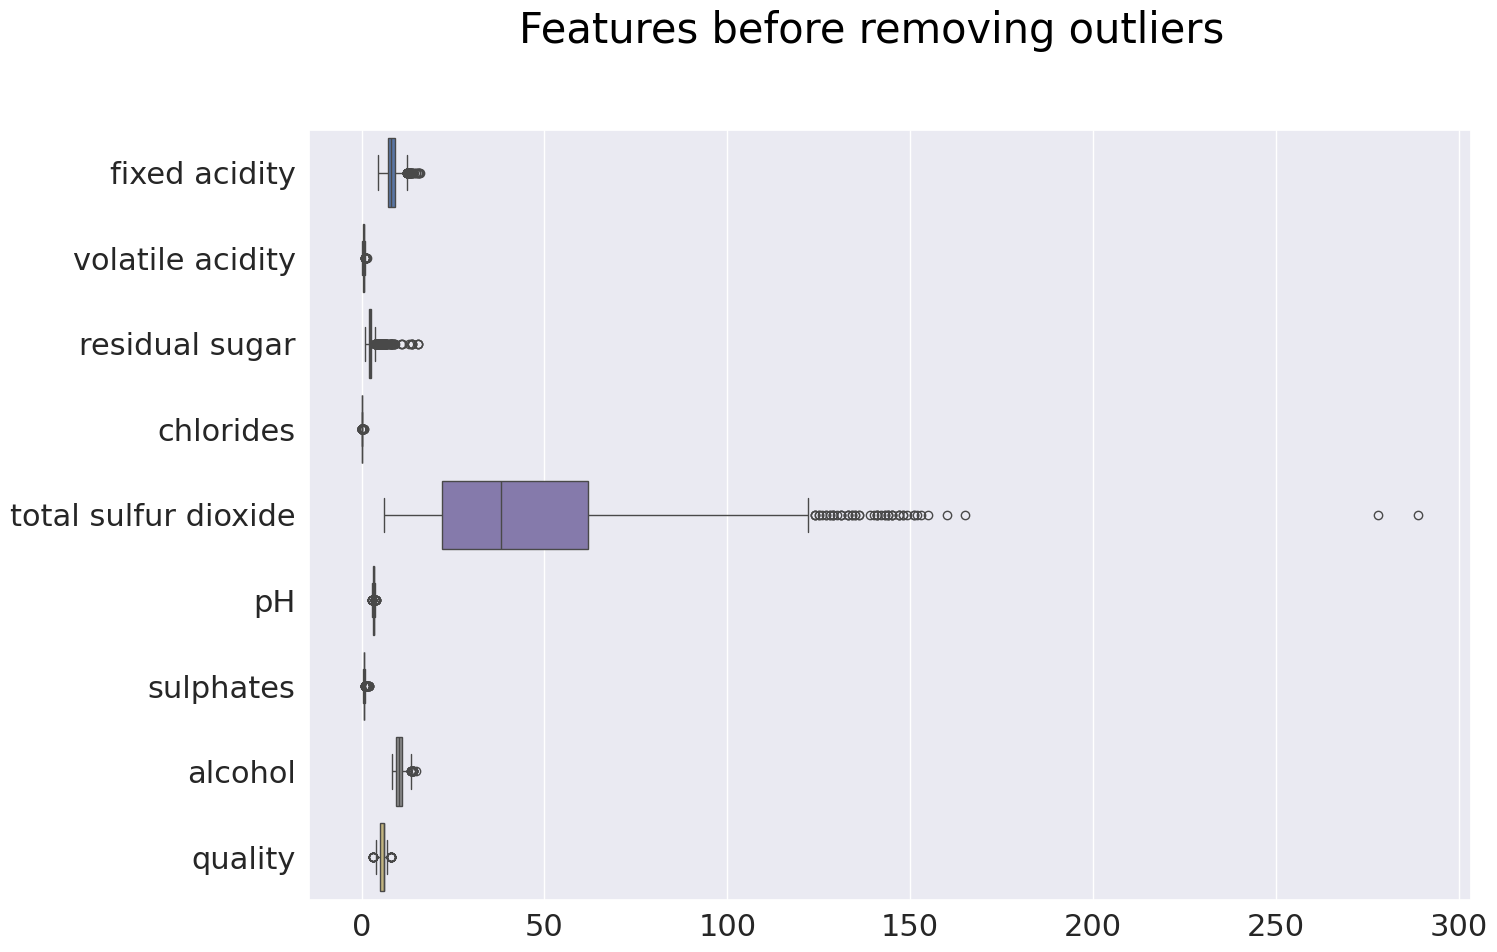

In [7]:
box_plot(wine_dataset, title="Features before removing outliers")

In [8]:
find_outliers(wine_dataset["fixed acidity"])
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["fixed acidity"]>12.3499].index)

find_outliers(wine_dataset["volatile acidity"])
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["volatile acidity"]>1.0075].index)

find_outliers(wine_dataset["residual sugar"])
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["residual sugar"]>3.6500].index)

find_outliers(wine_dataset["chlorides"])
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["chlorides"]>0.1175].index)

find_outliers(wine_dataset["total sulfur dioxide"])
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["total sulfur dioxide"]>115.5].index)

find_outliers(wine_dataset["pH"])
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["pH"]>3.68].index)
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["pH"]<2.96].index)

find_outliers(wine_dataset["sulphates"])
find_dataset = wine_dataset.drop(wine_dataset[wine_dataset["sulphates"]>0.9499].index)

find_outliers(wine_dataset["alcohol"])
wine_dataset = wine_dataset.drop(wine_dataset[wine_dataset["alcohol"]>13.4583].index)

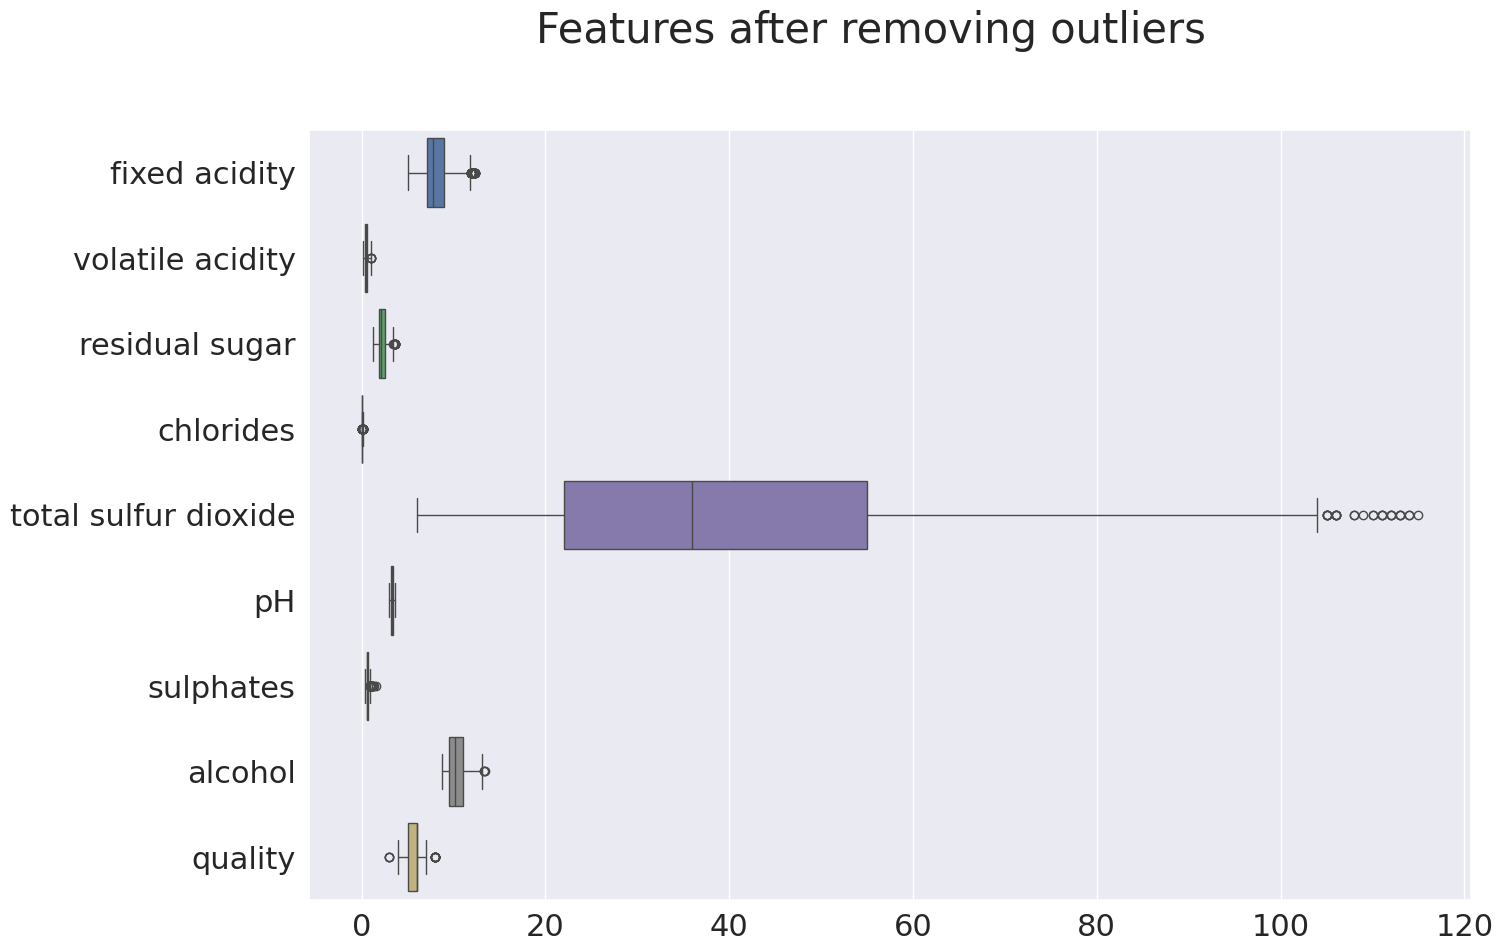

In [9]:
box_plot(wine_dataset, title="Features after removing outliers")

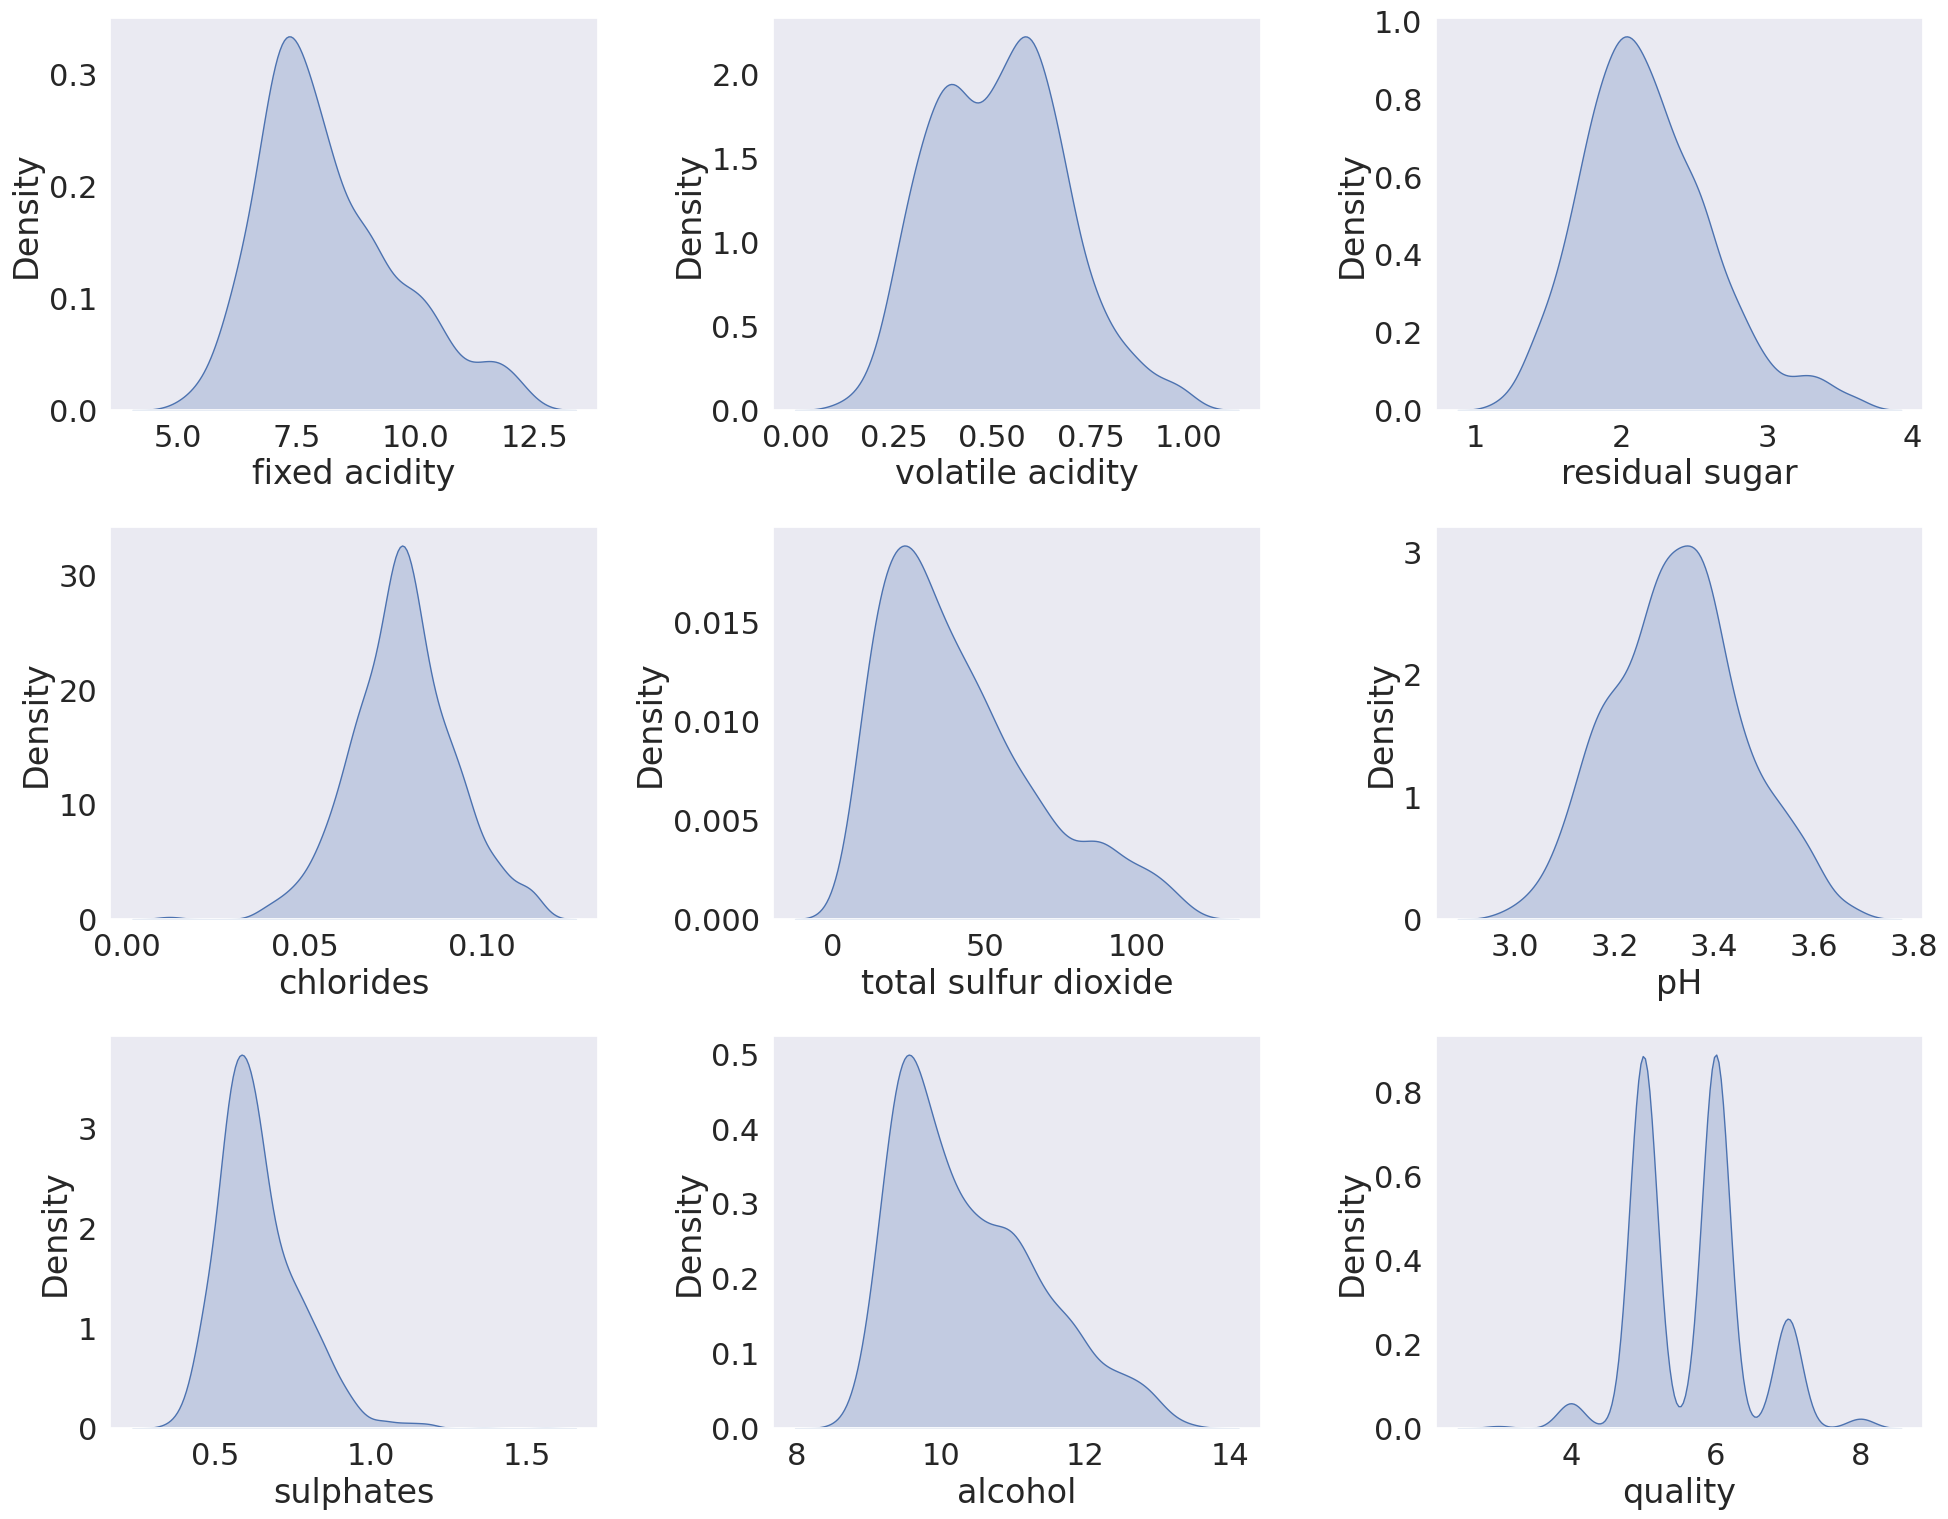

In [10]:
# Feature distribution
plt.figure(figsize=(20, 20))
for i, col in enumerate(list(wine_dataset.columns.values)):
    plt.subplot(4, 3, i+1)
    sns.kdeplot(wine_dataset[col], fill= True)
    plt.grid()
    plt.tight_layout()

In [11]:
print("Skewness\n", wine_dataset.skew())

Skewness
 fixed acidity           0.739864
volatile acidity        0.281431
residual sugar          0.622168
chlorides              -0.045761
total sulfur dioxide    0.902416
pH                      0.100933
sulphates               1.236643
alcohol                 0.736488
quality                 0.315686
dtype: float64


In [12]:
# Apply Box Cox transformation
numeric_features = list(wine_dataset.dtypes[(wine_dataset.dtypes != "str") & (wine_dataset.dtypes !='object')].index)

skewed_features = wine_dataset[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()


# Apply Box Cox transformation
l_opt = {}

for feat in skewness.index:
    wine_dataset[feat], l_opt[feat] = boxcox((wine_dataset[feat]+1))

skewed_features2 = wine_dataset[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

,Skew,New Skew
sulphates,1.235113,0.001044
total sulfur dioxide,0.901299,-0.021222
fixed acidity,0.738949,0.020492
alcohol,0.735576,0.114162


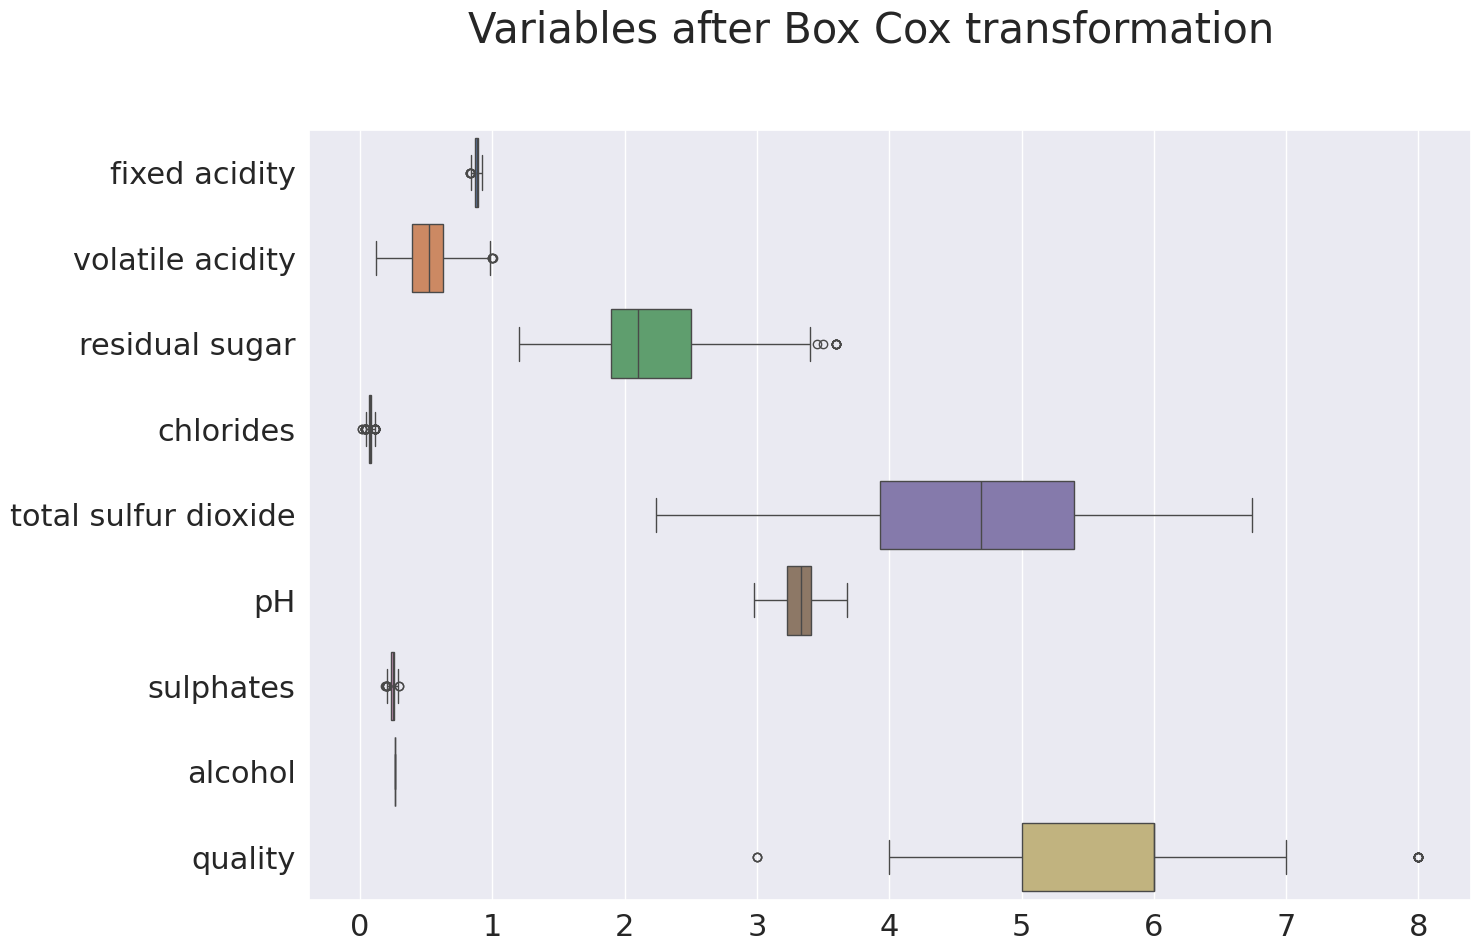

In [13]:
box_plot(wine_dataset, title="Variables after Box Cox transformation")

In [14]:
#check shape of final dataset
print(wine_dataset.shape)
print(list(wine_dataset.columns))

(1213, 9)
['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol', 'quality']


In [15]:
X=np.array(wine_dataset.iloc[:,0:8])
y=np.array(wine_dataset.iloc[:,8])

In [16]:
#make a copy of the dataset
wine_copy = wine_dataset.copy(deep=True)

inputs = torch.from_numpy(X).type(torch.float)
outputs = torch.from_numpy(y).type(torch.float)
dataset = TensorDataset(inputs, outputs)
print('Shape of input tensor and target tensor::  ',inputs.shape, outputs.shape)
print('datatype of input tensor and target tensor::  ',inputs.dtype, outputs.dtype)

Shape of input tensor and target tensor::   torch.Size([1213, 8]) torch.Size([1213])
datatype of input tensor and target tensor::   torch.float32 torch.float32


In [17]:
################
# NEURAL NETWORK
################

In [18]:
# to use with GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
        #return torch.device('cpu')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device

device(type='cpu')

In [19]:
#input and output
input_columns=list(wine_dataset.columns)[:-1]
output_columns = ['quality']

#Convert dataframe to numpy arrays
inputs_array = wine_copy[input_columns].to_numpy()
targets_array = (wine_copy[output_columns]-3).to_numpy().squeeze().astype(np.compat.long)

#Convert numpy array to torch tensor
inputs = torch.from_numpy(inputs_array).type(torch.float)
outputs = torch.from_numpy(targets_array).type(torch.long)

#Create a Tensor Dataset
WineTensorDataset = TensorDataset(inputs, outputs)
WineTensorDataset

#I split in 80% train and 20% val
num_rows = len(wine_copy)
val_percent = 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

random_seed = 42
torch.manual_seed(random_seed)
#To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

train_df, val_df = random_split(WineTensorDataset, [train_size, val_size])
len(train_df), len(val_df)

#Pick a batch size for DataLoader
batch_size=64
train_loader = DataLoader(train_df, batch_size, shuffle=True)
val_loader = DataLoader(val_df, batch_size)
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

In [20]:
input_size = len(input_columns)
output_size = 6

#Loss function
loss_fn = F.cross_entropy

class WineQuality(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        return self.net(x)

In [21]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [22]:
## Setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = WineQuality()
model.to(device)

torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

dataset = ConcatDataset([inputs_array, targets_array])

num_epochs=50
batch_size=64
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

In [23]:
def train_epoch(model,device,dataloader,loss_fn,optimizer, scheduler):
    train_loss,train_correct=0.0, 0
    model.train()
    for inputs, labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()
    scheduler.step()
    return train_loss,train_correct

def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for inputs, labels in dataloader:

        inputs,labels = inputs.to(device),labels.to(device)
        output = model(inputs)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*inputs.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()
    return valid_loss,val_correct

In [24]:
# using feature engineered dataset
inputs = torch.from_numpy(inputs_array).type(torch.float)
outputs = torch.from_numpy(targets_array).type(torch.long)

#Create a Tensor Dataset
dataset = TensorDataset(inputs, outputs)

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = WineQuality()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.15)

    history = {'train_loss': [], 'test_loss': [],'train_err':[],'test_err':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer,scheduler)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_err = 1- (train_correct / len(train_loader.sampler))
        test_loss = test_loss / len(test_loader.sampler)
        test_err = 1- (test_correct / len(test_loader.sampler))

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Error {:.2f} AVG Test Error {:.2f} ".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_err,
                                                                                                   test_err))
        if (epoch == num_epochs-1):
            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)
            history['train_err'].append(train_err)
            history['test_err'].append(test_err)

    foldperf['fold{}'.format(fold+1)] = history


Fold 1
Epoch:1/50 AVG Training Loss:1.258 AVG Test Loss:1.164 AVG Training Error 0.59 AVG Test Error 0.52 
Epoch:2/50 AVG Training Loss:1.166 AVG Test Loss:1.162 AVG Training Error 0.58 AVG Test Error 0.52 
Epoch:3/50 AVG Training Loss:1.149 AVG Test Loss:1.167 AVG Training Error 0.58 AVG Test Error 0.52 
Epoch:4/50 AVG Training Loss:1.156 AVG Test Loss:1.157 AVG Training Error 0.57 AVG Test Error 0.52 
Epoch:5/50 AVG Training Loss:1.163 AVG Test Loss:1.158 AVG Training Error 0.57 AVG Test Error 0.52 
Epoch:6/50 AVG Training Loss:1.145 AVG Test Loss:1.173 AVG Training Error 0.56 AVG Test Error 0.52 
Epoch:7/50 AVG Training Loss:1.195 AVG Test Loss:1.231 AVG Training Error 0.58 AVG Test Error 0.52 
Epoch:8/50 AVG Training Loss:1.167 AVG Test Loss:1.158 AVG Training Error 0.57 AVG Test Error 0.52 
Epoch:9/50 AVG Training Loss:1.163 AVG Test Loss:1.162 AVG Training Error 0.58 AVG Test Error 0.55 
Epoch:10/50 AVG Training Loss:1.129 AVG Test Loss:1.214 AVG Training Error 0.54 AVG Test Erro

In [25]:
# get performance
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=10
for f in range(1,k+1):

    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_err']))
    testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_err']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Err: {:.2f} \t Average Test Err: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))

Performance of 10 fold cross validation
Average Training Loss: 1.033 	 Average Test Loss: 1.062 	 Average Training Err: 0.47 	 Average Test Err: 0.48


In [26]:
input_size = 11
output_size = 6

#Loss function
loss_fn = F.cross_entropy


class WineQuality(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        return self.net(x)

In [27]:
# original dataset
#input and output
wine_copy2 = wine_dataset2.copy(deep=True)
input_columns=list(wine_dataset2.columns)[:-1]
output_columns = ['quality']
print(input_columns)
print(output_columns)
#Convert dataframe to numpy arrays
inputs_array = wine_copy2[input_columns].to_numpy()
targets_array = (wine_copy2[output_columns]-3).to_numpy().squeeze().astype(np.compat.long)

inputs = torch.from_numpy(inputs_array).type(torch.float)
outputs = torch.from_numpy(targets_array).type(torch.long)

#Create a Tensor Dataset
dataset = TensorDataset(inputs, outputs)

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = WineQuality()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.15)

    history = {'train_loss': [], 'test_loss': [],'train_err':[],'test_err':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer,scheduler)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_err = 1- (train_correct / len(train_loader.sampler))
        test_loss = test_loss / len(test_loader.sampler)
        test_err = 1- (test_correct / len(test_loader.sampler))

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Error {:.2f} AVG Test Error {:.2f} ".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_err,
                                                                                                   test_err))
        if (epoch == num_epochs-1):
            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)
            history['train_err'].append(train_err)
            history['test_err'].append(test_err)

    foldperf['fold{}'.format(fold+1)] = history


['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
['quality']
Fold 1
Epoch:1/50 AVG Training Loss:1.339 AVG Test Loss:1.169 AVG Training Error 0.58 AVG Test Error 0.46 
Epoch:2/50 AVG Training Loss:1.154 AVG Test Loss:1.133 AVG Training Error 0.50 AVG Test Error 0.45 
Epoch:3/50 AVG Training Loss:1.149 AVG Test Loss:1.135 AVG Training Error 0.49 AVG Test Error 0.49 
Epoch:4/50 AVG Training Loss:1.139 AVG Test Loss:1.151 AVG Training Error 0.49 AVG Test Error 0.45 
Epoch:5/50 AVG Training Loss:1.136 AVG Test Loss:1.153 AVG Training Error 0.49 AVG Test Error 0.49 
Epoch:6/50 AVG Training Loss:1.132 AVG Test Loss:1.110 AVG Training Error 0.52 AVG Test Error 0.44 
Epoch:7/50 AVG Training Loss:1.113 AVG Test Loss:1.059 AVG Training Error 0.47 AVG Test Error 0.44 
Epoch:8/50 AVG Training Loss:1.120 AVG Test Loss:1.129 AVG Training Error 0.52 AVG Test Error 0.57 
Epoch:9/5

In [28]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=10
for f in range(1,k+1):

    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_err']))
    testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_err']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Err: {:.2f} \t Average Test Err: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))

Performance of 10 fold cross validation
Average Training Loss: 0.930 	 Average Test Loss: 0.982 	 Average Training Err: 0.41 	 Average Test Err: 0.44


In [29]:
################################
# MULTICLASS LOGISTIC REGRESSION
################################

In [30]:
class MultiClassLogisticRegression:
    def __init__(self):
        self.classes = None
        self.iter = None
        self.lr = None
        self.w = None

    # need to train our w matrix by iterations
    def fit(self, X, y, lr=.0001, iterations =1000):
        X = np.array(X)
        y = np.array(y)

        # set parameters
        self.classes = np.unique(y)
        self.iter = iterations
        self.lr = lr
        self.w = np.zeros((len(np.unique(y)), X.shape[1]))

        # transform y
        y= self.one_hot(y)

        # run training iterations
        for i in range(iterations):
            score = np.dot(X, self.w.T)
            P = self.softmax(score)
            error = P-y
            gradient = np.dot(error.T, X)
            self.w -= (lr * gradient)
        return self

    # transforms score (detail in paper)
    def softmax(self, score):
        s = np.max(score, axis=1)
        s = s[:, np.newaxis]
        e_x = np.exp(score - s)
        div = np.sum(e_x, axis=1)
        div = div[:, np.newaxis]
        return e_x / div

    def predict(self, X):
        X = np.array(X)
        return np.vectorize(lambda i: self.classes[i])(np.argmax(self.softmax(np.dot(X, self.w.T)), axis=1))

    # Use this to encode our y (detail in paper)
    def one_hot(self, y):
        classList = list(np.unique(y))
        oneHotMatrix = np.zeros((len(y), len(classList)))
        for i, j in enumerate(y):
            oneHotMatrix[i][classList.index(j)] = 1
        return oneHotMatrix

    def score(self, y_true, y_pred):
        score = np.sum(y_true == y_pred) / len(y_true)
        return score

    def error(self, y_true, y_pred):
        return 1-self.score(y_true, y_pred)

In [31]:
%%time
#### Feature engineered
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Run 10 fold cross validation
kf =KFold(n_splits=10, shuffle=False)

# define X as dataframe
X=(wine_dataset.iloc[:,0:8])
y=np.array(wine_dataset.iloc[:,8])

train_err= []
test_err= []
std_dev = []

LR = MultiClassLogisticRegression()

# split()  method generate indices to split data into training and test set.
# .iloc integer based indexing
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # model w/ training data
    LR.fit(X_train, y_train,lr=.0001, iterations=10000)
    y_train_pred = LR.predict(X_train)

    train_error = (LR.error(np.array(y_train), y_train_pred))
    train_err.append(train_error)

    # model w/ test data
    y_test_pred = LR.predict(X_test)
    test_error = (LR.error(np.array(y_test), y_test_pred))
    test_err.append(test_error)

# Statistics
train_err = np.asarray(train_err)
print("train error: ", train_err)
print("\ntrain mean: ", train_err.mean())
print("\nstandard deviation: ", train_err.var())

test_err = np.asarray(test_err)
print("\ntest error: ", test_err)
print("\ntest mean: ", test_err.mean())
print("\nstandard deviation: ", test_err.var())

train error:  [0.48579285 0.46562786 0.47112741 0.48443223 0.48168498 0.46886447
 0.47435897 0.47802198 0.48076923 0.47344322]

train mean:  0.4764123212565009

standard deviation:  4.159246320976346e-05

test error:  [0.42622951 0.52459016 0.55737705 0.39669421 0.46280992 0.53719008
 0.51239669 0.47933884 0.44628099 0.47933884]

test mean:  0.48222463080883343

standard deviation:  0.002351071632692728
CPU times: user 31.4 s, sys: 67.5 ms, total: 31.5 s
Wall time: 33.1 s


In [32]:
%%time
# original data set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Run 10 fold cross validation
kf =KFold(n_splits=10, shuffle=False)

# define X as dataframe
X=(wine_dataset2.iloc[:,0:11])
y=np.array(wine_dataset2.iloc[:,11])

train_err= []
test_err= []
std_dev = []

LR = MultiClassLogisticRegression()

# split()  method generate indices to split data into training and test set.
# .iloc integer based indexing
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # model w/ training data
    LR.fit(X_train, y_train, lr=.0001, iterations=20000)
    y_train_pred = LR.predict(X_train)

    train_error = (LR.error(np.array(y_train), y_train_pred))
    train_err.append(train_error)

    # model w/ test data
    y_test_pred = LR.predict(X_test)
    test_error = (LR.error(np.array(y_test), y_test_pred))
    test_err.append(test_error)

# Statistics
train_err = np.asarray(train_err)
print("train error: ", train_err)
print("\ntrain mean: ", train_err.mean())
print("\nstandard deviation: ", train_err.var())

test_err = np.asarray(test_err)
print("\ntest error: ", test_err)
print("\ntest mean: ", test_err.mean())
print("\nstandard deviation: ", test_err.var())

train error:  [0.55246699 0.55038221 0.46629604 0.52466991 0.59068798 0.53926338
 0.51980542 0.61362057 0.54343294 0.53055556]

train mean:  0.5431180989884951

standard deviation:  0.0014331881936694181

test error:  [0.35625    0.51875    0.48125    0.55625    0.6875     0.51875
 0.53125    0.4875     0.53125    0.65408805]

test mean:  0.5322838050314466

standard deviation:  0.007546912407662873
CPU times: user 1min 28s, sys: 182 ms, total: 1min 28s
Wall time: 1min 30s


In [33]:
################################################
# Naive-Bayes w/ Marginal Gaussian Distributions
################################################

In [34]:
class GaussianNaiveBayes:
    def __init__(self):
        self.classes = None
        self.mean = None
        self.variance = None
        self.prior = None

    # Set vars needed to compute GNB
    def fit(self, X, y):
        self.mean = np.array(X.groupby(by=y).mean())
        self.variance = np.array(X.groupby(by=y).var())
        self.classes = np.unique(y)
        self.prior = 1/len(self.classes)
        return

    def gnb_calc(self, x_val, x_mean, x_var):
        # added 1 to variance as variance could be 0 which causes error
        # just setting x_var to 0 will not result in correct predictions
        return (1/(np.sqrt(2 * np.pi * (x_var+1)))) * np.exp(-(((x_val - x_mean) ** 2))/(2 * (x_var+1)))

    def predict(self, X):
        featureCount = X.shape[1]
        X_pred = []

        # Make prediction for each datapoint in X
        for data in X:

            # calculate prob of feature given class
            prob = []
            for i in range(len(self.classes)):
                for j in range(featureCount):

                    # get mean, var, value of feature
                    class_mean = self.mean[i][j]
                    class_var = self.variance[i][j]
                    feature_value = data[j]

                    # now calculate the GNB
                    prob.append([self.gnb_calc(feature_value, class_mean,
                                               class_var)])

            prob = np.array(prob)

            # split prob into classes
            classes_prob = np.vsplit(prob, len(self.classes))

            # calculate the likeliness of class
            final_prob = []

            for i in classes_prob:
                class_prob = np.prod(i) * self.prior
                final_prob.append(class_prob)

            # get the index of max prob
            prob_index = final_prob.index(max(final_prob))

            # append class that has max prob
            prediction = self.classes[prob_index]
            X_pred.append(prediction)

        return np.array(X_pred)

    def score(self, y_true, y_pred):
        score = np.sum(y_true == y_pred) / len(y_true)
        return score

    def error(self, y_true, y_pred):
        return 1-self.score(y_true, y_pred)

In [35]:
%%time
# feature engineered
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Run 10 fold cross validation
kf =KFold(n_splits=10, shuffle=False)

# define X as dataframe
X=(wine_dataset.iloc[:,0:8])
y=np.array(wine_dataset.iloc[:,8])

train_err= []
test_err= []
std_dev = []

GNB = GaussianNaiveBayes()

# split()  method generate indices to split data into training and test set.
# .iloc integer based indexing
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # model w/ training data
    GNB.fit(X_train, y_train)
    y_train_pred = GNB.predict(np.array(X_train))
    GNB_train_error = (GNB.error(np.array(y_train), y_train_pred))
    train_err.append(GNB_train_error)

    # model w/ test data
    y_test_pred = GNB.predict(np.array(X_test))
    GNB_test_error = (GNB.error(np.array(y_test), y_test_pred))
    test_err.append(GNB_test_error)

# Statistics
train_err = np.asarray(train_err)
print("train error: ", train_err)
print("\ntrain mean: ", train_err.mean())
print("\nstandard deviation: ", train_err.var())

test_err = np.asarray(test_err)
print("\ntest error: ", test_err)
print("\ntest mean: ", test_err.mean())
print("\nstandard deviation: ", test_err.var())

train error:  [0.62419798 0.61869844 0.62786434 0.62271062 0.60805861 0.60622711
 0.59249084 0.59615385 0.5989011  0.99908425]

train mean:  0.6494387143562212

standard deviation:  0.01372298472576724

test error:  [0.54098361 0.62295082 0.62295082 0.55371901 0.71900826 0.7107438
 0.66942149 0.66115702 0.5785124  0.98347107]

test mean:  0.666291830375288

standard deviation:  0.014523074061291075
CPU times: user 4.86 s, sys: 23.8 ms, total: 4.88 s
Wall time: 5.03 s


In [36]:
%%time
# original data set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Run 10 fold cross validation
kf =KFold(n_splits=10, shuffle=False)

# define X as dataframe
X=(wine_dataset2.iloc[:,0:11])
y=np.array(wine_dataset2.iloc[:,11])

train_err= []
test_err= []
std_dev = []

GNB = GaussianNaiveBayes()

# split()  method generate indices to split data into training and test set.
# .iloc integer based indexing
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # model w/ training data
    GNB.fit(X_train, y_train)
    y_train_pred = GNB.predict(np.array(X_train))
    GNB_train_error = (GNB.error(np.array(y_train), y_train_pred))
    train_err.append(GNB_train_error)

    # model w/ test data
    y_test_pred = GNB.predict(np.array(X_test))
    GNB_test_error = (GNB.error(np.array(y_test), y_test_pred))
    test_err.append(GNB_test_error)

# Statistics
train_err = np.asarray(train_err)
print("train error: ", train_err)
print("\ntrain mean: ", train_err.mean())
print("\nstandard deviation: ", train_err.var())

test_err = np.asarray(test_err)
print("\ntest error: ", test_err)
print("\ntest mean: ", test_err.mean())
print("\nstandard deviation: ", test_err.var())

train error:  [0.72828353 0.71299514 0.71160528 0.68867269 0.71369006 0.70882557
 0.69423211 0.74982627 0.68172342 0.68263889]

train mean:  0.707249295421203

standard deviation:  0.0004122975071452907

test error:  [0.58125    0.66875    0.7625     0.6875     0.70625    0.79375
 0.7375     0.7625     0.65625    0.73584906]

test mean:  0.7092099056603773

standard deviation:  0.0035632243736650033
CPU times: user 5.8 s, sys: 22.2 ms, total: 5.82 s
Wall time: 5.86 s
